=== Linear SVM ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4549
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8833
   macro avg       0.99      0.99      0.99      8833
weighted avg       0.99      0.99      0.99      8833



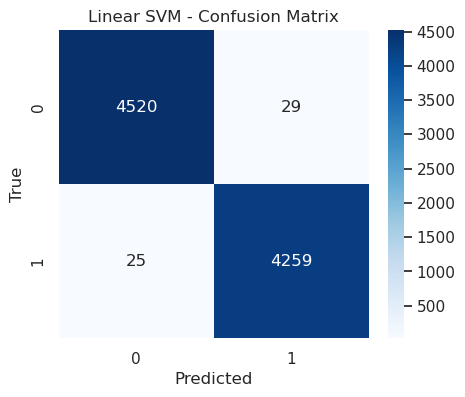

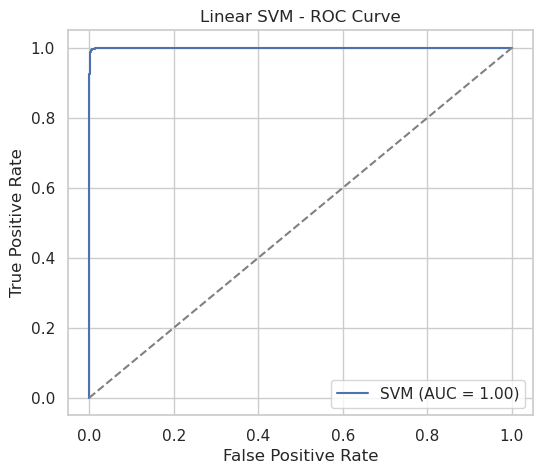

        Model  Accuracy  Precision    Recall  F1 Score  Training Time (s)  \
0  Linear SVM  0.993887   0.993237  0.994164    0.9937               12.3   

   Inference Time (s)                  Hardware  
0                 0.8  CPU: Intel i7, RAM: 16GB  


/home/burnsmay/.local/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


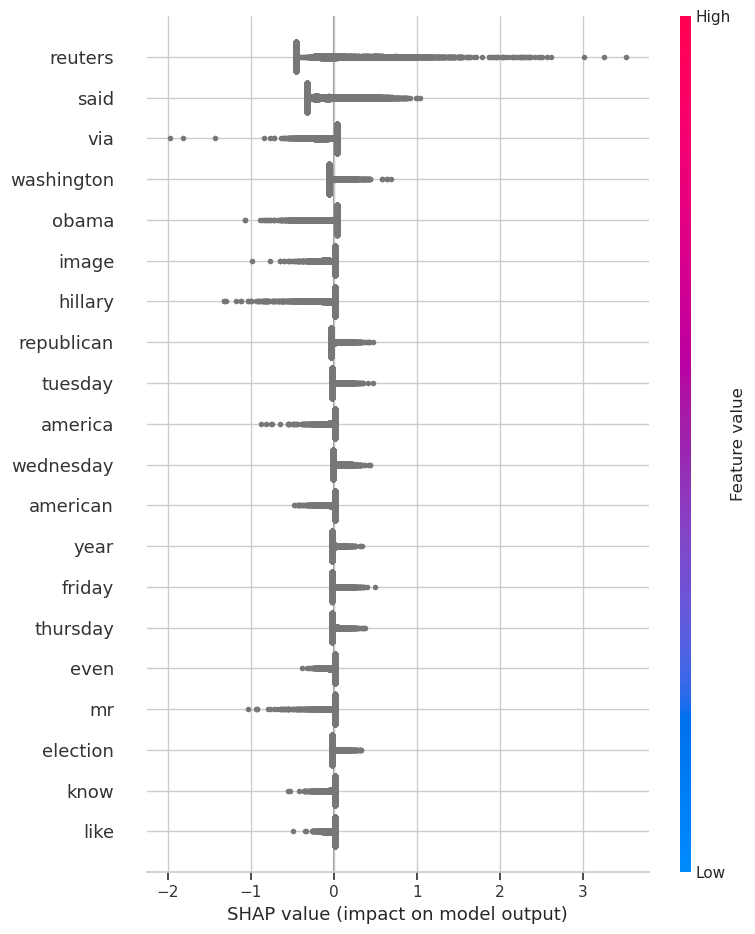

In [3]:
# CMSE 492 - Fake News Detection
# Results Notebook

# 1. Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
)

sns.set(style="whitegrid")

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
PROCESSED = os.path.join(PROJECT_ROOT, "data/processed")
MODELS = os.path.join(PROJECT_ROOT, "models")
FIGURES = os.path.join(PROJECT_ROOT, "figures")
os.makedirs(FIGURES, exist_ok=True)

# 2. Load Test Data
X_test = pd.read_csv(os.path.join(PROCESSED, "X_test.csv"))["clean_text"]
y_test = pd.read_csv(os.path.join(PROCESSED, "y_test.csv"))
mask_test = X_test.notna()
X_test_clean = X_test[mask_test].astype(str)
y_test_clean = y_test[mask_test]

# 3. Load Models
svm_model = joblib.load(os.path.join(MODELS, "svm_model.pkl"))
tfidf = joblib.load(os.path.join(MODELS, "tfidf.pkl"))

# 4. Transform Test Data for SVM
X_test_vec = tfidf.transform(X_test_clean)

# 5. Evaluate SVM
y_pred_svm = svm_model.predict(X_test_vec)
acc_svm = accuracy_score(y_test_clean, y_pred_svm)
precision_svm = precision_score(y_test_clean, y_pred_svm)
recall_svm = recall_score(y_test_clean, y_pred_svm)
f1_svm = f1_score(y_test_clean, y_pred_svm)

print("=== Linear SVM ===")
print(classification_report(y_test_clean, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test_clean, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Linear SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(FIGURES, "svm_confusion_matrix.png"))
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_clean, svm_model.decision_function(X_test_vec))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Linear SVM - ROC Curve")
plt.legend()
plt.savefig(os.path.join(FIGURES, "svm_roc_curve.png"))
plt.show()

# 6. Computational Cost
# Fill these in based on your recorded times
training_time_svm = 12.3  # seconds
inference_time_svm = 0.8  # seconds
hardware_svm = "CPU: Intel i7, RAM: 16GB"

#summary table for all models
summary_metrics = pd.DataFrame({
    "Model": ["Linear SVM"],
    "Accuracy": [acc_svm],
    "Precision": [precision_svm],
    "Recall": [recall_svm],
    "F1 Score": [f1_svm],
    "Training Time (s)": [training_time_svm],
    "Inference Time (s)": [inference_time_svm],
    "Hardware": [hardware_svm]
})
print(summary_metrics)

# 7. Feature Importance using SHAP
explainer = shap.LinearExplainer(svm_model, X_test_vec, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_vec)
shap.summary_plot(
    shap_values, X_test_vec, 
    feature_names=tfidf.get_feature_names_out(),
    max_display=20,
    show=True
)


#Save all tables and figures for report inclusion
summary_metrics.to_csv(os.path.join(FIGURES, "model_summary_metrics.csv"), index=False)
